In [1]:
import os
import sys

data_fitting_py_files_dir = os.path.abspath("../py_files/")
sys.path.insert(0, data_fitting_py_files_dir)

helper_func_py_files_dir = os.path.abspath("../../../vampires_on_sky_calibration/programs/py_files/")
sys.path.insert(0, helper_func_py_files_dir)

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import general
import data_plotting
import reading_data
import instrument_matrices

/home/rebeccaz/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Start-Up Information

In [2]:
HWP_angs = np.array([0., 11.25, 22.5, 33.75, 45., 56.25, 67.5, 78.75])
IMR_angs = np.array([45., 57.5, 70., 82.5, 95., 107.5, 120., 132.5])
wavelengths = np.array([625, 675, 725, 750, 775])
angles = [HWP_angs, IMR_angs]

In [3]:
# Last index is for choosing the wavelength

wavelength_index = 1
wavelength = 675

double_differences = np.load("../../data/20220428/double_difference_new_darks_median_grid.npy")[:, :, wavelength_index]
double_sums = np.load("../../data/20220428/double_sum_new_darks_median_grid.npy")[:, :, wavelength_index]
double_difference_errs = np.load("../../data/20220428/double_difference_sem_new_darks_median_grid.npy")[:, :, wavelength_index]
double_sum_errs = np.load("../../data/20220428/double_sum_sem_new_darks_median_grid.npy")[:, :, wavelength_index]
data = np.array([double_differences, double_sums])
stds = np.array([double_difference_errs, double_sum_errs])

print(np.shape(data))

reshaped_data = general.reshape_and_flatten(data)
reshaped_stds = general.reshape_and_flatten(stds)

(2, 8, 8)


# Setting Parameter Bounds & Guesses

In [4]:
# NOTE: Customized angle bounds for each parameter
IMR_angle_bound = 1
LP_angle_bound = 5
HWP_angle_bound = 5
FLC_angle_bound = (-5, 5)

model = instrument_matrices.full_system_mueller_matrix

bounds = ((0, 1), # EM Gain Ratio
          (-1 * LP_angle_bound, LP_angle_bound), # linear polarizer angle (degrees)
          (-1, 1), # delta_FLC (waves)
          (-1, 1), # delta_opt (waves)
          (-1, 1), # delta_derot (waves)
          (0, 0.5), # delta_HWP (waves)
          FLC_angle_bound, # rot_FLC (degrees)
          (-90, 90), # rot_opt (degrees)
          (-1 * IMR_angle_bound, IMR_angle_bound), # offset_derot (degrees)
          (-1 * HWP_angle_bound, HWP_angle_bound), # offset_HWP (degrees)
          (0, 1)) # epsilon_opt (unitless)

# Ordering of parameters
# em_gain, pol_theta, delta_FLC, delta_opt, delta_derot, delta_HWP, rot_FLC, 
# rot_opt, offset_derot, offset_HWP, epsilon_opt, angles


# Plot Initial Guess

(128,)
[0, 0, 0, 0.45649443676091783, -2.642, 0.32208684844990476, 1, -0.14961975453168286, 0.01868703913240439, -2.3950912229452315, 0.3287256097107294, 1.5231767001488516, 0.8849557522123894]


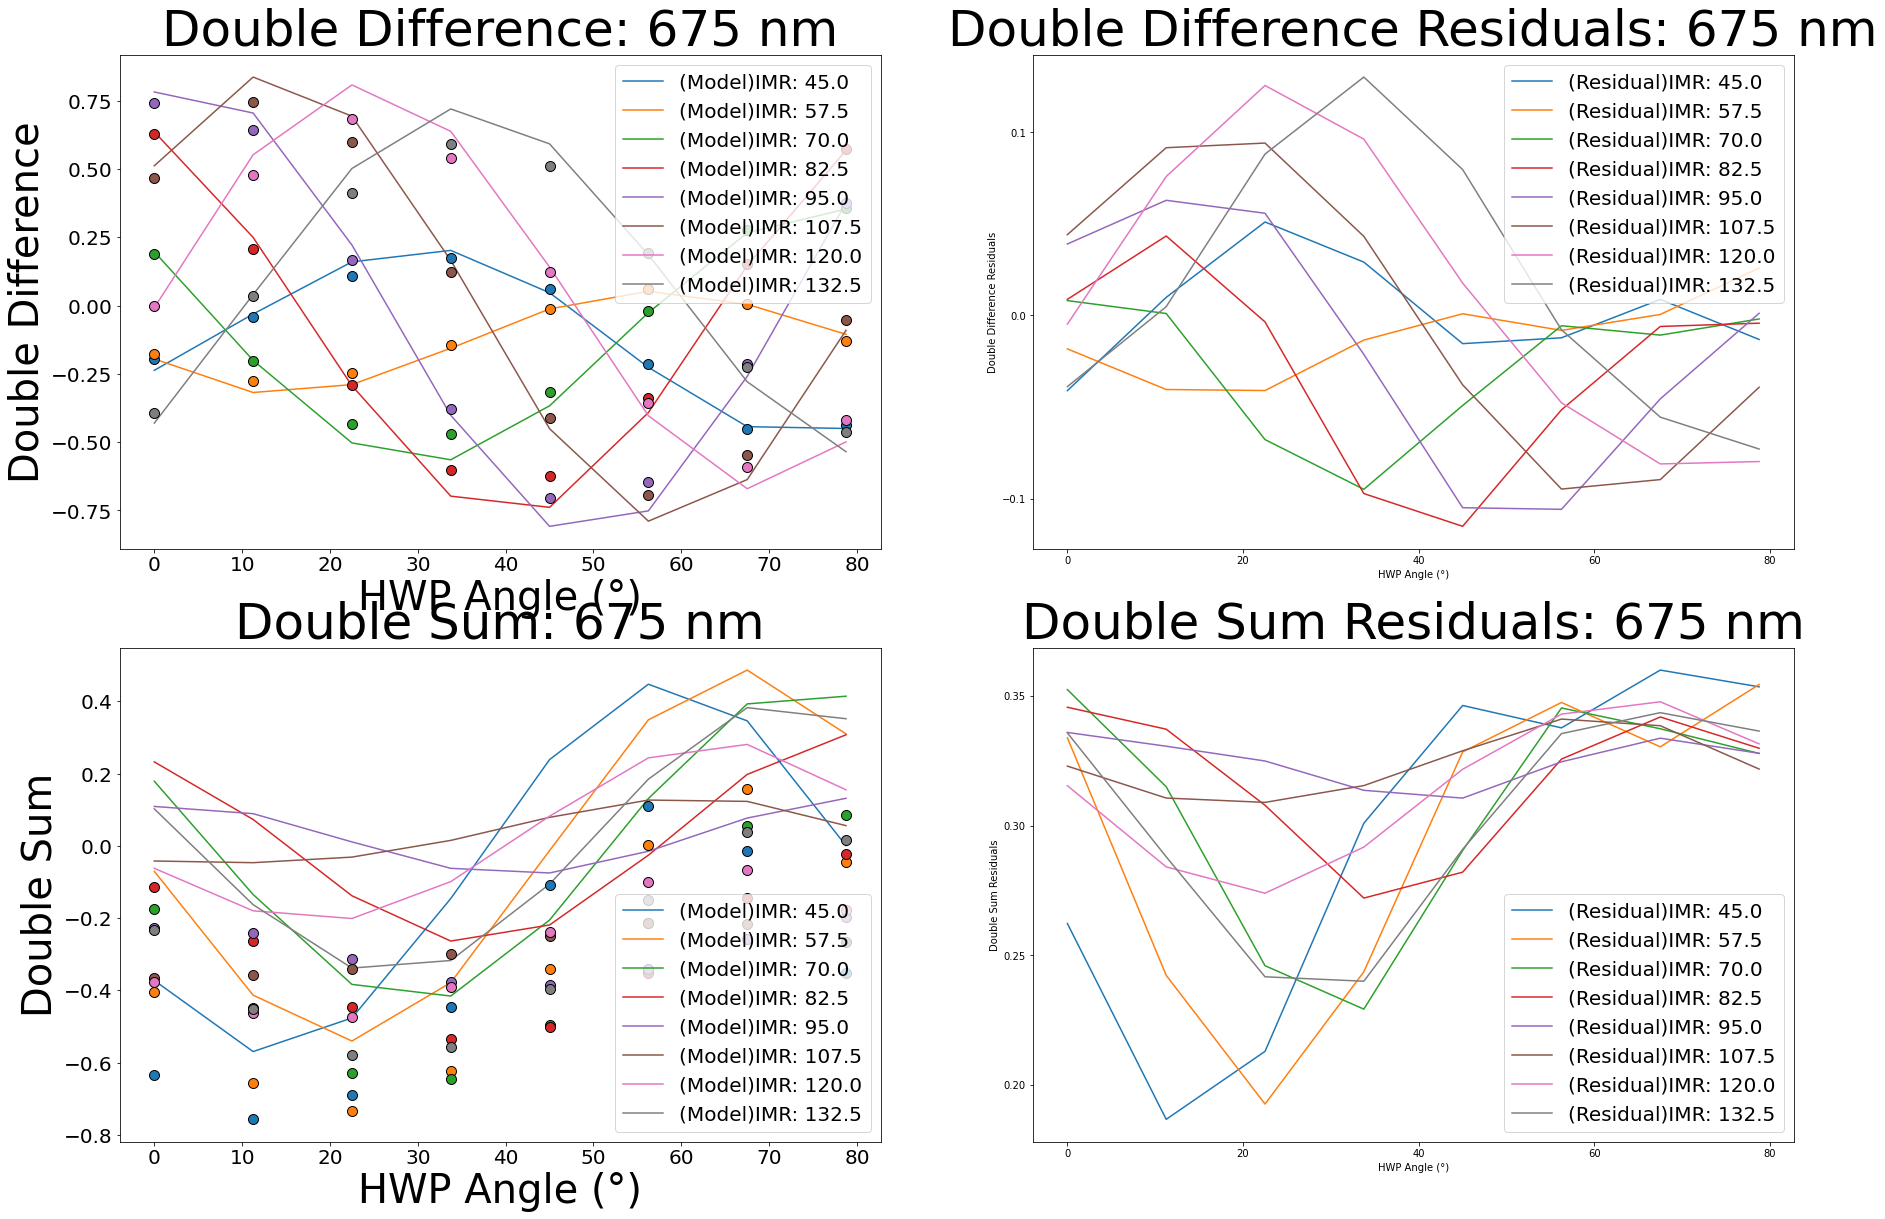

In [6]:
# Small value to remove error bars
log_f = -10

# Defining model angles
model_angles = np.linspace(0, 90, 100)


# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits - having zeros for angles that're too large
theta_pol = 0.18
delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
epsilon_m3 = 0  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 1 / 1.13  # Add your actual em_gain value
delta_HWP = 0.5  # Add your actual delta_HWP value
offset_HWP = 0.06  # Add your actual offset_HWP value
delta_derot = 0.31  # Add your actual delta_derot value
offset_derot = -0.01  # Add your actual offset_derot value
delta_opts = -0.17 # Add your actual delta_opts value
epsilon_opts = 0.01  # Add your actual epsilon_opts value
rot_opts = -4.83  # Add your actual rot_opts value
delta_FLC = 0.34  # Add your actual delta_FLC value
rot_FLC = -1.42  # Add your actual rot_FLC value

# New values from MCMC!
# theta_pol = 0.18,
# delta_HWP = 0.5,  # Add your actual delta_HWP value
# offset_HWP = 0.06,  # Add your actual offset_HWP value
# delta_derot = 0.31,  # Add your actual delta_derot value
# offset_derot = -0.01,  # Add your actual offset_derot value
# delta_opts = -0.17 , # Add your actual delta_opts value
# epsilon_opts = 0.01,  # Add your actual epsilon_opts value
# rot_opts = -74.83,  # Add your actual rot_opts value
# delta_FLC = 0.34,  # Add your actual delta_FLC value
# rot_FLC = -1.42, # Add your actual rot_FLC value

# For changing specific parameters
# epsilon_m3 = epsilon_m3 / 1
# em_gain = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

initial_model = instrument_matrices.internal_calibration_mueller_matrix(theta_pol,
    model, fixed_params, HWP_angs, IMR_angs)

print(np.shape(initial_model))

initial_residuals = initial_model - reshaped_data

print(fixed_params)

data_plotting.plot_single_model_and_residuals(angles, angles, initial_model, data, 
    initial_residuals, stds, log_f, wavelength, fig_dimensions = (30, 20))

# Fitting for all parameters by the EM Gain

In [24]:
import numpy as np
from scipy.optimize import minimize

# Small value to remove error bars
log_f = -10

# Defining model angles
model_angles = np.linspace(0, 90, 100)

# List to store all the solutions 
solns = []

# Initial guess based on the parameters you want to minimize
initial_guess = np.array([theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, 
    delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC])

all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Fixed parameters not included in the fitting process
fixed_params = [delta_m3, epsilon_m3, offset_m3, em_gain]

# Define the bounds for the parameters (excluding em_gain)
bounds = [
    (-5, 5),  # theta_pol
    (0, 0.5),  # delta_HWP
    (-5, 5),  # offset_HWP
    (0, 0.5),  # delta_derot
    (-5, 5),  # offset_derot
    (-0.5, 0.5),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    (0, 0.5),  # delta_FLC
    (-90, 90)  # rot_FLC
]

# Defining the negative log-likelihood function
def nll(params, model, HWP_angs, IMR_angs, data, stds):
    theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC = params
    delta_m3, epsilon_m3, offset_m3, em_gain = fixed_params
    all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
        delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
        rot_FLC, em_gain]
    this_model = instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs)
    residuals = this_model - data
    
    # Debug print shapes
    # print("Model shape:", this_model.shape)
    # print("Data shape:", data.shape)
    # print("Stds shape:", stds.shape)
    
    likelihood = np.sum((residuals / stds) ** 2)
    return likelihood

# Initialize variables for the iterative minimization process
counter = 0
initial_likelihood = 100
post_likelihood = 90

# Starting off with the initial guess
model = instrument_matrices.full_system_mueller_matrix
initial_model = instrument_matrices.internal_calibration_mueller_matrix(initial_guess[0], model, all_params, HWP_angs, IMR_angs)

while post_likelihood < initial_likelihood:
    counter += 1

    initial_likelihood = post_likelihood

    # Calculate the initial model and residuals
    initial_model = instrument_matrices.internal_calibration_mueller_matrix(initial_guess[0], model, all_params, HWP_angs, IMR_angs)
    initial_residuals = initial_model - reshaped_data

    initial_likelihood = np.sum((initial_residuals / reshaped_stds) ** 2)

    print("Initial Likelihood: " + str(initial_likelihood))

    # Minimize the negative log-likelihood
    minimize_args = (model, HWP_angs, IMR_angs, reshaped_data, reshaped_stds)
    soln = minimize(nll, initial_guess, args=minimize_args, bounds=bounds, method="Nelder-Mead")

    # Save the solution
    solns.append(soln)

    # Recalculate the likelihood with the new solution
    theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC = soln.x
    delta_m3, epsilon_m3, offset_m3, em_gain = fixed_params
    all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
        delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
        rot_FLC, em_gain]
    post_likelihood = np.sum((instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs) - reshaped_data) / reshaped_stds ** 2)

    print("Iteration #" + str(counter) + ": " + str(post_likelihood))

    print("MAXIMUM LIKELIHOOD ESTIMATES")
    print("")
    print("theta_pol (degrees): " + str(theta_pol))
    print("delta_HWP (waves): " + str(delta_HWP))
    print("offset_HWP (degrees): " + str(offset_HWP))
    print("delta_derot (waves): " + str(delta_derot))
    print("offset_derot (degrees): " + str(offset_derot))
    print("delta_opts (waves): " + str(delta_opts))
    print("epsilon_opts: " + str(epsilon_opts))
    print("rot_opts (degrees): " + str(rot_opts))
    print("delta_FLC (waves): " + str(delta_FLC))
    print("rot_FLC (degrees): " + str(rot_FLC))

    reshaped_data = general.reshape_and_flatten(data)
    reshaped_stds = general.reshape_and_flatten(stds)

    model_1 = instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs)
    residuals_1 = model_1 - reshaped_data

    # Reset initial guess
    initial_guess = soln.x

    print("Post Likelihood: " + str(post_likelihood))


Initial Likelihood: 10803581.517578207
Iteration #1: 29725060.915706903
MAXIMUM LIKELIHOOD ESTIMATES

theta_pol (degrees): -2.1892477163241146
delta_HWP (waves): 0.49999485036589864
offset_HWP (degrees): -0.04266929376903317
delta_derot (waves): 0.316139888546892
offset_derot (degrees): 1.7537654518777774
delta_opts (waves): -0.1679817155760439
epsilon_opts: 1.6166954910317425e-06
rot_opts (degrees): -4.516044640445603
delta_FLC (waves): 0.3300760026576467
rot_FLC (degrees): -1.2571585654212374
Post Likelihood: 29725060.915706903


In [25]:
print(all_params[1 :])
print(soln.x)

[0, 0, 0.49999485036589864, -0.04266929376903317, 0.316139888546892, 1.7537654518777774, -0.1679817155760439, 1.6166954910317425e-06, -4.516044640445603, 0.3300760026576467, -1.2571585654212374, 0.8849557522123894]
[-2.18924772e+00  4.99994850e-01 -4.26692938e-02  3.16139889e-01
  1.75376545e+00 -1.67981716e-01  1.61669549e-06 -4.51604464e+00
  3.30076003e-01 -1.25715857e+00]


# Plot Final Likelihood

(128,)
[-2.18924772e+00  4.99994850e-01 -4.26692938e-02  3.16139889e-01
  1.75376545e+00 -1.67981716e-01  1.61669549e-06 -4.51604464e+00
  3.30076003e-01 -1.25715857e+00]
[-0.15767471  0.06445419  0.24848506  0.29220968  0.16345747 -0.06840999
 -0.26056664 -0.29455446 -0.11283867 -0.20087511 -0.17220788 -0.04457183
  0.11312246  0.20975358  0.18257424  0.04633612  0.2716115  -0.08884178
 -0.38634657 -0.4579221  -0.26516491  0.09007984  0.4037528   0.48053774
  0.69860633  0.33747492 -0.21089097 -0.62677077 -0.678726   -0.33516834
  0.21494008  0.64839347  0.81979847  0.75953829  0.25585506 -0.39194395
 -0.80872107 -0.75458516 -0.25697505  0.39694743  0.51690126  0.84252114
  0.67625893  0.11415488 -0.51931512 -0.85174386 -0.68354984 -0.11463622
 -0.02309211  0.50075971  0.72956259  0.53578828  0.02327689 -0.51460032
 -0.75283744 -0.54503341 -0.45138959 -0.05581976  0.36025195  0.56614716
  0.44599151  0.05725248 -0.37761892 -0.59034292 -0.3510627  -0.52916133
 -0.43840602 -0.12514689  

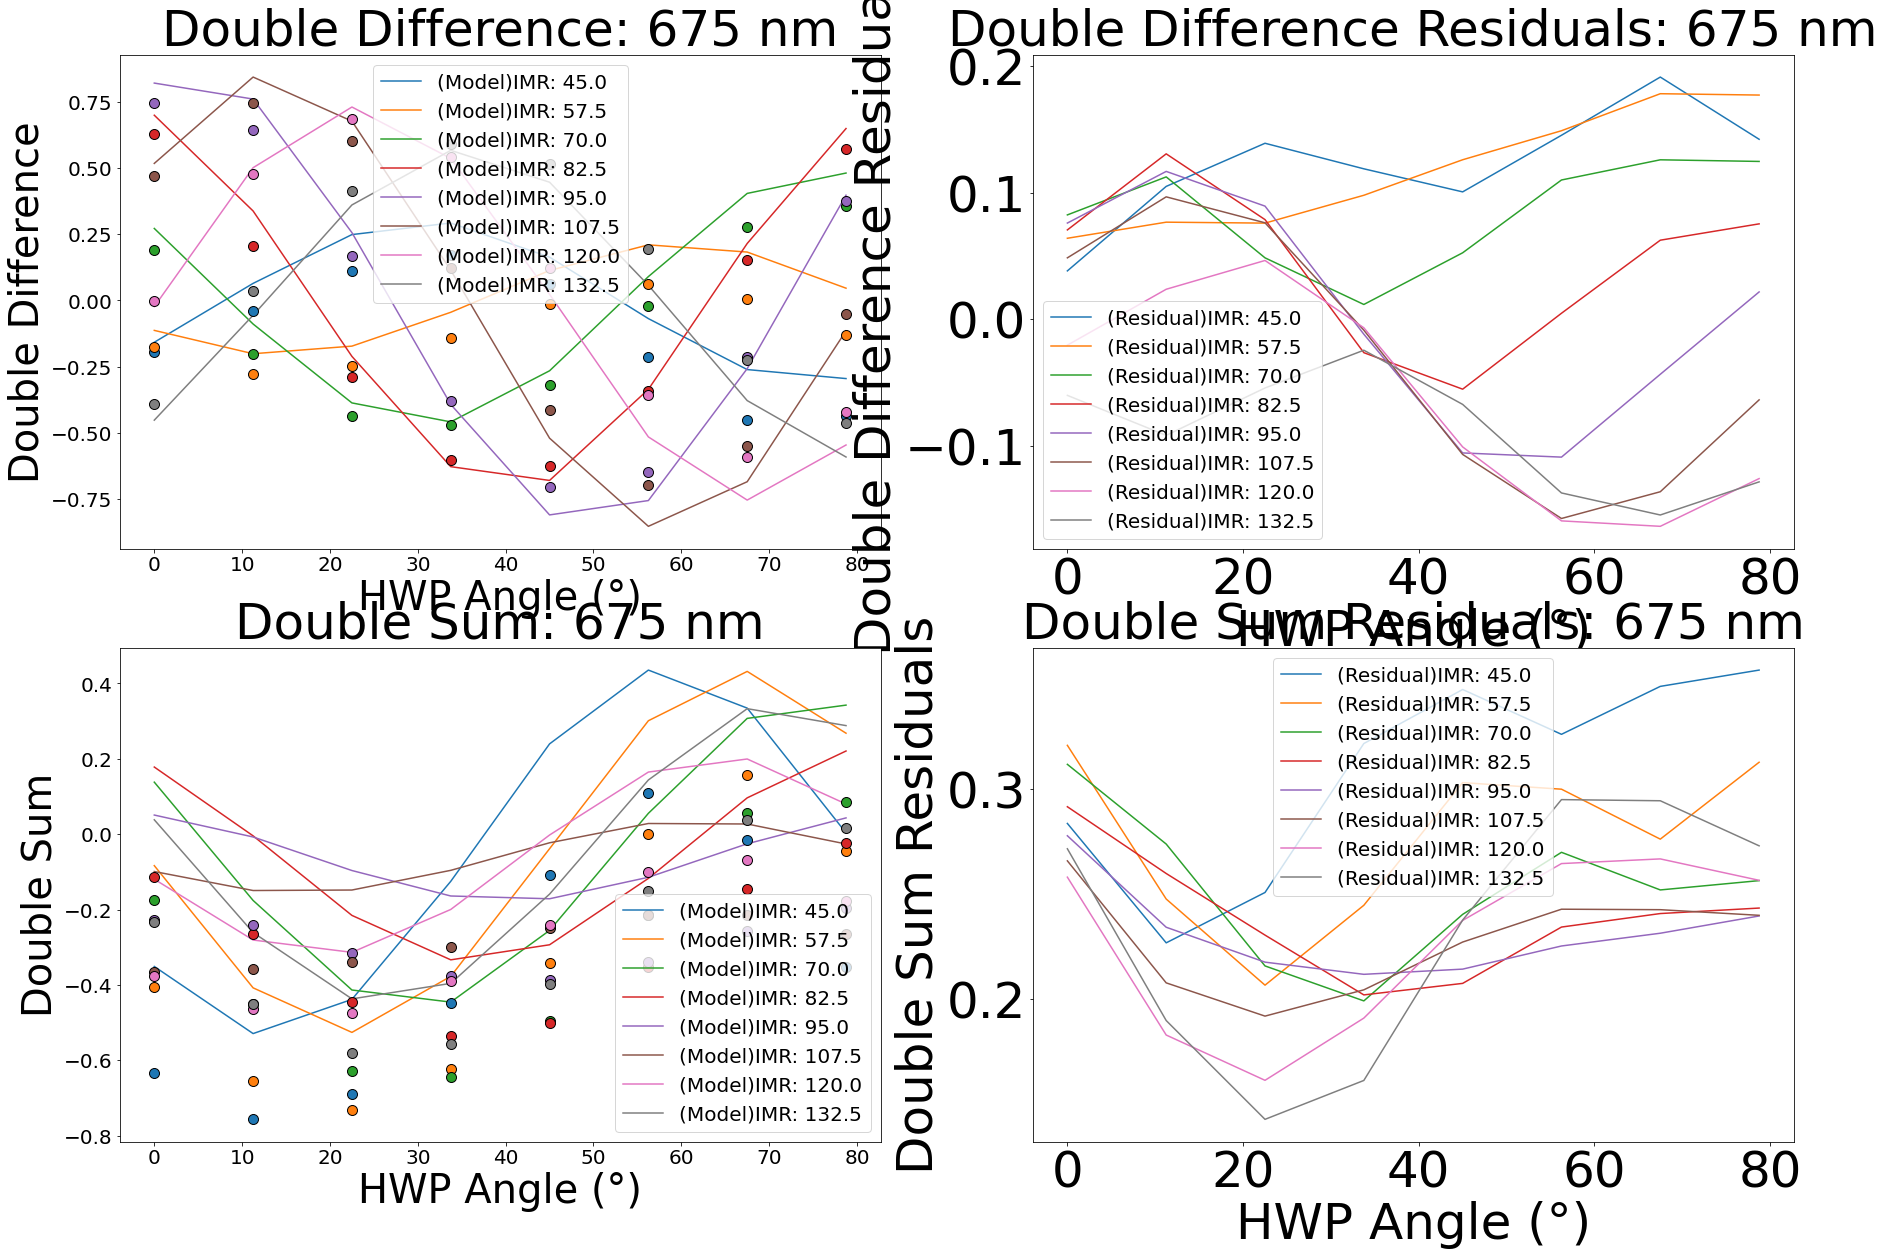

In [26]:
# Small value to remove error bars
log_f = -10

# Defining model angles
model_angles = np.linspace(0, 90, 100)

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

fixed_params_with_soln = np.array([0, 0, 0] + list(soln.x[1 :]) + [em_gain])
initial_model = instrument_matrices.internal_calibration_mueller_matrix(soln.x[0],
    model, fixed_params_with_soln, HWP_angs, IMR_angs)

print(np.shape(initial_model))

initial_residuals = initial_model - reshaped_data

print(soln.x)
print(initial_model)

data_plotting.plot_single_model_and_residuals(angles, angles, initial_model, data, 
    initial_residuals, stds, log_f, wavelength, fig_dimensions = (30, 20))